# Calculate the high vs low years for temperature, ice fraction and nutrietns on a point by point basis using the POP grid... this will take longer, but could potenitally just look nicer?... High vs low years are slected using the 90th and 10th percentile. 
##  Units: 
    1. Temperature ($^o$ C)
    2. Ice Fraction (unitless)
    3. NO$_3$ concentration (mmol m$^{-3}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
import statistics as stats
from statistics import mean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Import Phytoplankton biomass information. 

In [7]:
phytoC_summer_ds=xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_summer_bm.nc');
phytoC_spring_ds=xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_spring_bm.nc');
phytoC_fall_ds=xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_fall_bm.nc');
phytoC_winter_ds= xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_winter_bm.nc');

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_summer_bm.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_summer_bm.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset TLAT
			found dataset TLONG
			found dataset phytoC_small_150m
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x10000 ext_ncid 0x10000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/phytoC_small_summer_bm.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 4 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 1 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 2 name: nlon len: 320 unlimited: 0
		 VARIABLE - varid: 0 name: time ndims: 1 dimscale: 1 dim

In [8]:
phytoC_summer_bm = np.array(phytoC_summer_ds.phytoC_small_150m)
phytoC_spring_bm = np.array(phytoC_spring_ds.phytoC_small_150m)
phytoC_fall_bm = np.array(phytoC_fall_ds.phytoC_small_150m)
phytoC_winter_bm = np.array(phytoC_winter_ds.phytoC_small_150m)

		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_var_all: ncid 0x10000 varid 3
			NC4_get_vars: var->hdr.name phytoC_small_150m mem_nc_type 5
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_var_all: ncid 0x10000 varid 3
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_dim: ncid 0x10000 dimid 1
		NC4_inq_dim: ncid 0x10000 dimid 2
		NC4_inq_att: ncid 0x10000 varid 3 n

## High vs Low NO$_3$

In [9]:
## Bring in Grid information -- /glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/
grid_inds = sorted(glob('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_SPECTRA_TAREA.*.nc', recursive=True))
ds= xr.open_mfdataset(grid_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [10]:
%%time
NO3_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc');

CPU times: user 4.75 ms, sys: 6.94 ms, total: 11.7 ms
Wall time: 73.4 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset NO3
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x110000 ext_ncid 0x110000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlimited

In [11]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter.NO3,axis=0) # Size (12,384,320)

		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x11000

CPU times: user 397 ms, sys: 1.01 s, total: 1.4 s
Wall time: 3.1 s


In [12]:
NO3_ds = np.array(NO3_ds_inter.NO3)

		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_dim: ncid 0x110000 dimid 0
		NC4_inq_dim: ncid 0x110000 dimid 1
		NC4_inq_dim: ncid 0x110000 dimid 2
		NC4_inq_dim: ncid 0x110000 dimid 3
		NC4_inq_var_all: ncid 0x110000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x110000 varid 4
		NC4_inq_var_all: ncid 0x11000

In [13]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 1.63 s, sys: 262 ms, total: 1.89 s
Wall time: 4.01 s


In [14]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 11.1 s, sys: 821 ms, total: 11.9 s
Wall time: 16.5 s


In [15]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

In [16]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_temp = np.empty([12,384,320]) ; low_no3_years_temp[:] = np.nan
high_no3_years_temp = np.empty([12,384,320]) ; high_no3_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

## High vs Low Temperature 

In [17]:
%%time
temp_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc');

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset TEMP
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x120000 ext_ncid 0x120000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlim

CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 906 ms


In [18]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter.TEMP,axis=0) # Size (384,320)
temp_ds = np.array(temp_ds_inter.TEMP)

		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_dim: ncid 0x120000 dimid 0
		NC4_inq_dim: ncid 0x120000 dimid 1
		NC4_inq_dim: ncid 0x120000 dimid 2
		NC4_inq_dim: ncid 0x120000 dimid 3
		NC4_inq_var_all: ncid 0x120000 varid 4
			NC4_get_vars: var->hdr.name TEMP mem_nc_type 6
		NC4_inq_var_all: ncid 0x120000 varid 4
		NC4_inq_var_all: ncid 0x1200

In [19]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 1.46 s, sys: 251 ms, total: 1.72 s
Wall time: 2.11 s


In [20]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 11.1 s, sys: 842 ms, total: 12 s
Wall time: 15.1 s


In [21]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 686 ms, sys: 0 ns, total: 686 ms
Wall time: 777 ms


In [22]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,384,320]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,384,320]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

CPU times: user 8.04 s, sys: 66.6 ms, total: 8.1 s
Wall time: 12.7 s


## High vs Low ICE Fraction Years

In [23]:
%%time
ECOSYS_IFRAC_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 7.5 ms, sys: 13.8 ms, total: 21.3 ms
Wall time: 187 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset ECOSYS_IFRAC
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x130000 ext_ncid 0x130000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - di

In [24]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC,axis=0) # Size (12,384,320)
ECOSYS_IFRAC_ds = np.array(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC)

		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 3
		NC4_inq_var_all: ncid 0x130000 varid 4
			NC4_get_vars: var->hdr.name ECOSYS_IFRAC mem_nc_type 6
		NC4_inq_var_all: ncid 0x130000 varid 4
		NC4_inq_var_all: nci

In [25]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

CPU times: user 1.5 s, sys: 261 ms, total: 1.76 s
Wall time: 1.8 s


In [26]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [27]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [28]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,384,320]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,384,320]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

## Plot phytoplankton biomass interannually 

## NO$_3$

In [29]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_summer = np.empty([384,320]) ; low_no3_years_summer[:] = np.nan
high_no3_years_summer = np.empty([384,320]) ; high_no3_years_summer[:] = np.nan

low_no3_years_spring = np.empty([384,320]) ; low_no3_years_spring[:] = np.nan
high_no3_years_spring = np.empty([384,320]) ; high_no3_years_spring[:] = np.nan

low_no3_years_fall = np.empty([384,320]) ; low_no3_years_fall[:] = np.nan
high_no3_years_fall = np.empty([384,320]) ; high_no3_years_fall[:] = np.nan

low_no3_years_winter = np.empty([384,320]) ; low_no3_years_winter[:] = np.nan
high_no3_years_winter = np.empty([384,320]) ; high_no3_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_spring[latitude,longitude] = np.nanmean(phytoC_spring_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_spring[latitude,longitude]= np.nanmean(phytoC_spring_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_no3_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_no3_years_winter[latitude,longitude]= np.nanmean(phytoC_winter_bm[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_no3_years_winter[latitude,longitude] = np.nanmean(phytoC_winter_bm[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 31.4 s, sys: 189 ms, total: 31.6 s
Wall time: 33.4 s


## Temperature 

In [30]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_summer = np.empty([384,320]) ; low_temp_years_summer[:] = np.nan
high_temp_years_summer = np.empty([384,320]) ; high_temp_years_summer[:] = np.nan

low_temp_years_spring = np.empty([384,320]) ; low_temp_years_spring[:] = np.nan
high_temp_years_spring = np.empty([384,320]) ; high_temp_years_spring[:] = np.nan

low_temp_years_fall = np.empty([384,320]) ; low_temp_years_fall[:] = np.nan
high_temp_years_fall = np.empty([384,320]) ; high_temp_years_fall[:] = np.nan

low_temp_years_winter = np.empty([384,320]) ; low_temp_years_winter[:] = np.nan
high_temp_years_winter = np.empty([384,320]) ; high_temp_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_spring[latitude,longitude] = np.nanmean(phytoC_spring_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_spring[latitude,longitude]= np.nanmean(phytoC_spring_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_temp_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_temp_years_winter[latitude,longitude]= np.nanmean(phytoC_winter_bm[low_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_temp_years_winter[latitude,longitude] = np.nanmean(phytoC_winter_bm[high_temp_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

## Ice Fraction

In [31]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years_summer = np.empty([384,320]) ; low_ice_years_summer[:] = np.nan
high_ice_years_summer = np.empty([384,320]) ; high_ice_years_summer[:] = np.nan

low_ice_years_spring = np.empty([384,320]) ; low_ice_years_spring[:] = np.nan
high_ice_years_spring = np.empty([384,320]) ; high_ice_years_spring[:] = np.nan

low_ice_years_fall = np.empty([384,320]) ; low_ice_years_fall[:] = np.nan
high_ice_years_fall = np.empty([384,320]) ; high_ice_years_fall[:] = np.nan

low_ice_years_winter = np.empty([384,320]) ; low_ice_years_winter[:] = np.nan
high_ice_years_winter = np.empty([384,320]) ; high_ice_years_winter[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_summer[latitude,longitude] = np.nanmean(phytoC_summer_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_spring[latitude,longitude] = np.nanmean(phytoC_spring_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_spring[latitude,longitude]= np.nanmean(phytoC_spring_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 

        low_ice_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_fall[latitude,longitude] = np.nanmean(phytoC_fall_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))

        low_ice_years_winter[latitude,longitude]= np.nanmean(phytoC_winter_bm[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
        high_ice_years_winter[latitude,longitude] = np.nanmean(phytoC_winter_bm[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 33.5 s, sys: 71.7 ms, total: 33.6 s
Wall time: 34.2 s


## import the ice fraction information

In [32]:
ice_frac_summer = np.nanmean(ECOSYS_IFRAC_ds[:,5:8,:,:],axis=1)
ice_frac_spring = np.nanmean(ECOSYS_IFRAC_ds[:,2:5,:,:],axis=1)
ice_frac_winter = np.nanmean(ECOSYS_IFRAC_ds[:,list(range(2)) + [-1],:,:],axis=1)
ice_frac_fall = np.nanmean(ECOSYS_IFRAC_ds[:,8:11,:,:],axis=1)

In [33]:
# This is loading the low and high temp, no3 and ice years when averging the whole Arctic... 
# I tried to do it grid by grid, but ice fraction works better when you average throughout the whole Arctic. 
high_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
low_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')

high_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')

high_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')
low_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')

In [34]:
## NO3
low_no3_years_summer_ice = ice_frac_summer[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_summer_ice = ice_frac_summer[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_spring_ice = ice_frac_spring[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_spring_ice= ice_frac_spring[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_fall_ice = ice_frac_fall[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_fall_ice = ice_frac_fall[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_winter_ice = ice_frac_winter[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_winter_ice = ice_frac_winter[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

## ice
low_ice_years_summer_ice = ice_frac_summer[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_summer_ice = ice_frac_summer[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_spring_ice = ice_frac_spring[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_spring_ice= ice_frac_spring[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_fall_ice = ice_frac_fall[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_fall_ice = ice_frac_fall[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_winter_ice = ice_frac_winter[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_winter_ice = ice_frac_winter[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_summer_ice = ice_frac_summer[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_summer_ice = ice_frac_summer[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_spring_ice = ice_frac_spring[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_spring_ice= ice_frac_spring[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_fall_ice = ice_frac_fall[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_fall_ice = ice_frac_fall[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_winter_ice = ice_frac_winter[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_winter_ice = ice_frac_winter[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

In [35]:
## Import POP grid information 
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

In [36]:
ice_frac_winter.shape

(62, 384, 320)

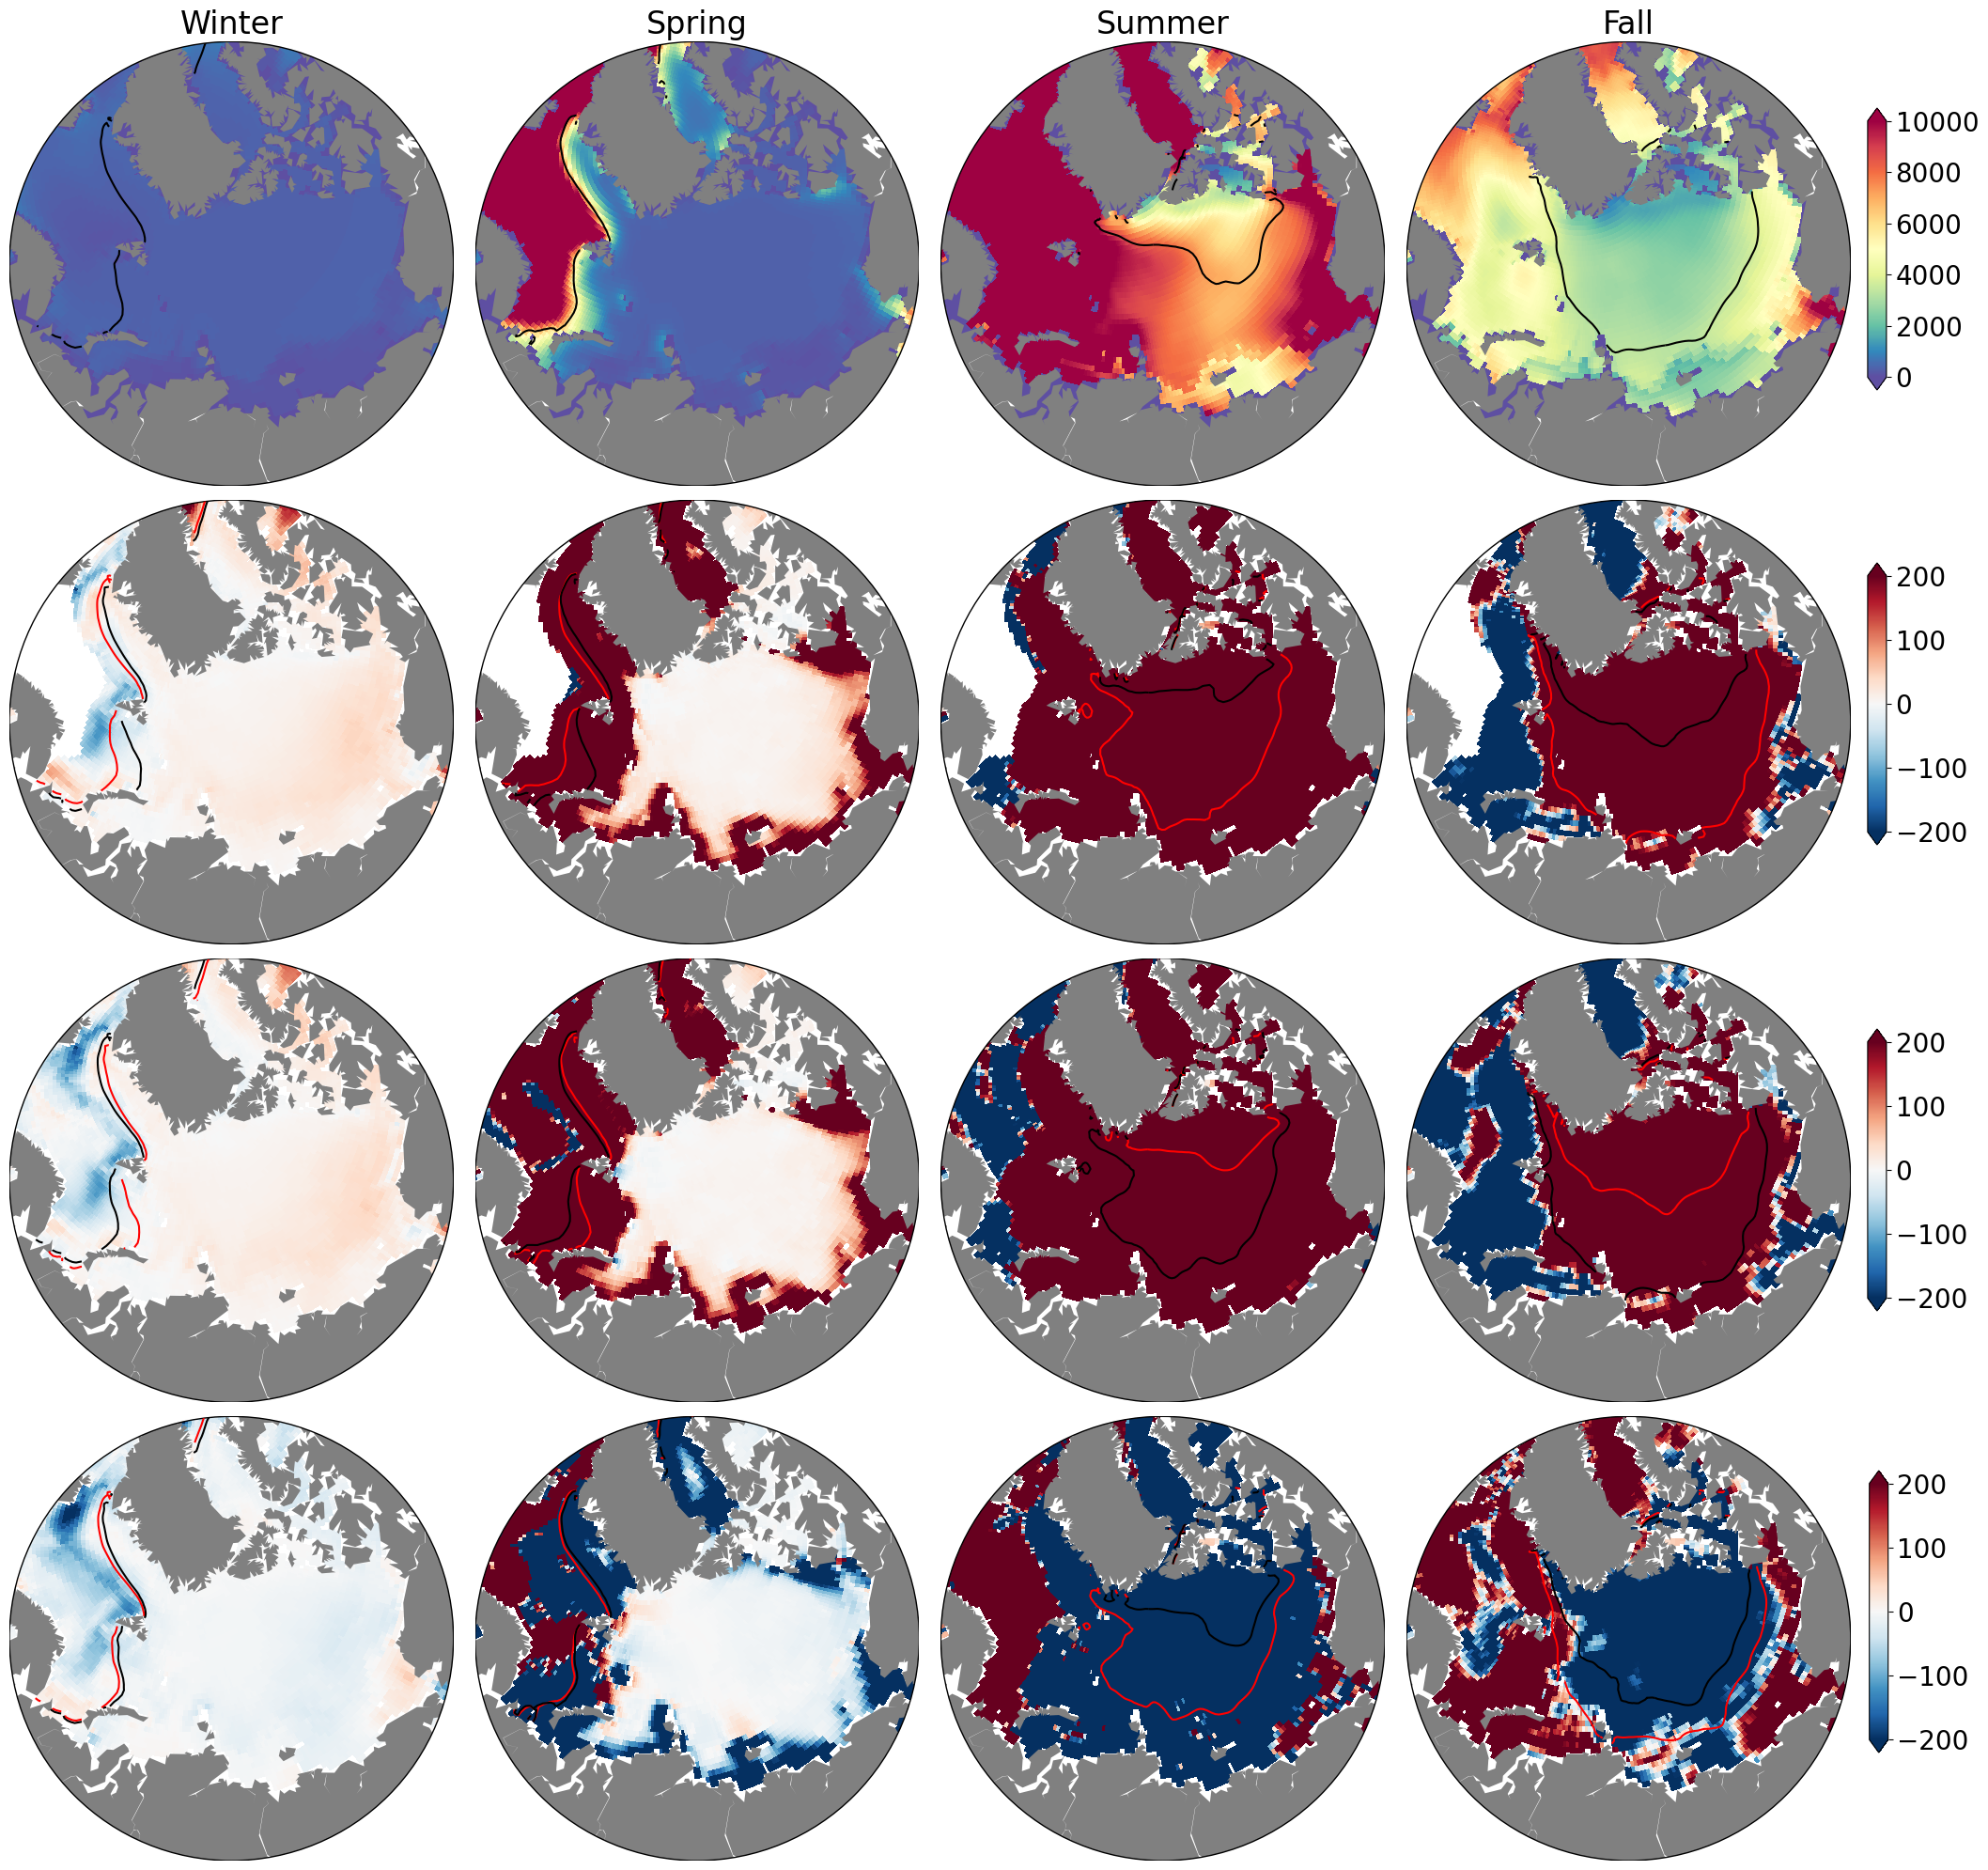

In [38]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
x_lon = ds.TLONG
y_lat= ds.TLAT
############ Seasonal Biomass #######################
# -------------  Winter  -------------
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_winter_bm,axis=0))
tlon, tlat, winter_ice = adjust_pop_grid(x_lon, y_lat, np.nanmean(ice_frac_winter,axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
ax.set_title('Winter', fontsize =24)

# -------------  Spring  -------------
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_spring_bm,axis=0))
tlon, tlat, spring_ice = adjust_pop_grid(x_lon, y_lat, np.nanmean(ice_frac_spring,axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
ax.set_title('Spring', fontsize =24)

# -------------  Summer  -------------
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_summer_bm,axis=0))
tlon, tlat, summer_ice = adjust_pop_grid(x_lon, y_lat, np.nanmean(ice_frac_summer,axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
ax.set_title('Summer', fontsize =24)

# -------------  Fall  ------------- 
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_fall_bm,axis=0))
tlon, tlat, fall_ice = adjust_pop_grid(x_lon, y_lat, np.nanmean(ice_frac_fall,axis=(0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
ax.set_title('Fall', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

############ Interannual Differences! #######################
vminn = -200
vmaxx = 200
#---------------------  Winter  ---------------------  
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = high_temp_years_winter-low_temp_years_winter
lon, lat, w_diff = adjust_pop_grid(x_lon, y_lat, winter_temp_diff)
tlon, tlat, winter_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
#----------------------------------------------------
#---------------------  Spring  --------------------- 
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = high_temp_years_spring-low_temp_years_spring
lon, lat, sp_diff = adjust_pop_grid(x_lon, y_lat, spring_temp_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#----------------------------------------------------
#---------------------  Summer  --------------------- 
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = high_temp_years_summer-low_temp_years_summer
lon, lat, s_diff = adjust_pop_grid(x_lon, y_lat, summer_temp_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#----------------------------------------------------
#---------------------  Fall  ---------------------  
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = high_temp_years_fall-low_temp_years_fall
lon, lat, f_diff = adjust_pop_grid(x_lon, y_lat, fall_temp_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

#----------------------------------------------------


######################### Ice Fraction#########################
#---------------------  Winter  ---------------------
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = low_ice_years_winter-high_ice_years_winter
lon, lat, w_diff = adjust_pop_grid(x_lon, y_lat, winter_ice_diff)
tlon, tlat, winter_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # ice in low ice years 

#----------------------------------------------------
#---------------------  Spring  --------------------- 
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = low_ice_years_spring-high_ice_years_spring
lon, lat, sp_diff = adjust_pop_grid(x_lon, y_lat, spring_ice_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in low ice years 

#-------------------------------------------,---------
#---------------------  Summer  --------------------- 
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = low_ice_years_summer-high_ice_years_summer
lon, lat, s_diff = adjust_pop_grid(x_lon, y_lat, summer_ice_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in low ice years

#----------------------------------------------------
#---------------------  Fall  ---------------------  
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = low_ice_years_fall-high_ice_years_fall
lon, lat, f_diff = adjust_pop_grid(x_lon, y_lat, fall_ice_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in low ice years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

######################## NO3 ###################################

#---------------------  Winter  --------------------- 
ax = fig.add_subplot(4,4, 13)
winter_no3_diff = high_no3_years_winter-low_no3_years_winter
tlon, tlat, winter_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
lon, lat, w_diff = adjust_pop_grid(x_lon, y_lat, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # ice in low no3 years 
#----------------------------------------------------
#---------------------  Spring  --------------------- 
ax = fig.add_subplot(4,4, 14)
spring_no3_diff = high_no3_years_spring-low_no3_years_spring
lon, lat, sp_diff = adjust_pop_grid(x_lon, y_lat, spring_no3_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in low no3 years 
#----------------------------------------------------
#---------------------  Summer  --------------------- 
ax = fig.add_subplot(4,4, 15)
summer_no3_diff = high_no3_years_summer-low_no3_years_summer
lon, lat, s_diff = adjust_pop_grid(x_lon, y_lat, summer_no3_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in low no3 years 
#----------------------------------------------------
#---------------------  Fall  --------------------- 
ax = fig.add_subplot(4,4, 16)
fall_no3_diff = high_no3_years_fall-low_no3_years_fall
lon, lat, f_diff = adjust_pop_grid(x_lon, y_lat, fall_no3_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(x_lon, y_lat, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(x_lon, y_lat, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in low no3 years 
cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_quarterly_small_biomass_interannual_percentile_diff_POPgrid.png',dpi=600, bbox_inches='tight')